<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/Python-Notebook-Banners/Code_challenge.png"  style="display: block; margin-left: auto; margin-right: auto;";/>
</div>


## Regression MCQ
© ExploreAI Academy

In this MCQ, we will engage in a comprehensive multiple-choice exercise, applying regression concepts and techniques to agricultural yield prediction. Through a series of challenges, we'll analyse variable relationships, feature engineering, model construction, and evaluation, enhancing our understanding and proficiency in regression analysis.

# Learning objectives
By the end of this notebook, you should be able to:

* Analyse predictor variables and their relationship with the target variable.
* Perform feature engineering tasks, including encoding categorical variables and scaling features.
* Construct and evaluate multiple linear regression models using appropriate libraries.
* Identify and address multicollinearity issues using regularisation techniques such as LASSO and Ridge regression.
* Interpret regression coefficients and understand their impact on the target variable.
* Implement decision tree models for prediction tasks, exploring both categorical and numerical data
* Calculate and interpret MSE and RMSE for model evaluation.


# The data
Join us on an intriguing exploration of a vast agricultural dataset. Uncover the intricate connections between geographic, weather, soil, and farm management features, all leading to a prediction of yield. Our mission? To decode these relationships and empower farmers with actionable insights for improved productivity and informed decision-making.

## Data dictionary

**1. Geographic features**

- **Field_ID:** A unique identifier for each field (BigInt).
 
- **Elevation:** The elevation of the field above sea level in metres (Float).

- **Latitude:** Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Longitude:** Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

- **Location:** Province the field is in (Text).

- **Slope:** The slope of the land in the field (Float).

**2. Weather features**

- **Rainfall:** Amount of rainfall in the area in mm (Float).

- **Min_temperature_C:** Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Max_temperature_C:** Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

- **Ave_temps:** Average temperature in Celcius (Float).

**3. Soil and crop features**

- **Soil_fertility:** A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

- **Soil_type:** Type of soil present in the field (Text).

- **pH:** pH level of the soil, which is a measure of how acidic/basic the soil is (Float).

**4. Farm management features**

- **Field_ID:** Corresponding field identifier (BigInt).

- **Pollution_level:** Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

- **Plot_size:** Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

- **Chosen_crop:** Type of crop chosen for cultivation (Text).

- **Annual_yield:** Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)

<br>

**5. Target variable**
- **Standard_yield:** Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

---

Let's import our database again, like we did last time. We won't use the weather data so it is commented out.

**Important:** Ensure that `data_ingestion.py` file and the `field_data_processor.py` files are stored in the same folder as your notebook, otherwise the data import will fail.
 
[Download files here](https://github.com/Explore-AI/Public-Data/raw/master/Maji_Ndogo/modules.zip)


In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

In [2]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2025-11-24 11:06:38,854 - data_ingestion - INFO - Database engine created successfully.
2025-11-24 11:06:39,042 - data_ingestion - INFO - Query executed successfully.
2025-11-24 11:06:39,042 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2025-11-24 11:06:39,050 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2025-11-24 11:06:40,108 - data_ingestion - INFO - CSV file read successfully from the web.


Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [3]:
# Validate the data
#!pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts =============================
platform win32 -- Python 3.13.5, pytest-8.3.4, pluggy-1.5.0 -- C:\Users\HP\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\HP\Downloads
plugins: anyio-4.7.0
collecting ... collected 4 items

validate_data.py::test_read_field_dataframe_shape PASSED                 [ 25%]
validate_data.py::test_field_dataframe_columns PASSED                    [ 50%]
validate_data.py::test_field_dataframe_non_negative_elevation PASSED     [ 75%]
validate_data.py::test_crop_types_are_valid PASSED                       [100%]

============================== 4 passed in 2.10s ==============================
Deleted sampled_field_df.csv


## Challenge 1: Understanding our variables and variable selection
In this section, we will analyse the predictor variables in our dataset and how they relate to the target variable.

### Question 1
How many predictors do we originally have in our dataset, and which of these are categorical in nature?

**Hint**: The `Field_ID` serves as a unique identifier for each field and does not provide any predictive value for modeling.

#### Options
* 16 predictors; Location, Soil_type, and Crop_type are categorical.
* 18 predictors; Location, Soil_type, and Crop_type are categorical.
* 17 predictors; Location, Soil_type, and Crop_type are categorical.
* 16 predictors; Location, Soil_type, and Plot_size are categorical.

In [4]:
# First, let's examine the dataset structure
print("Dataset shape:", dataset.shape)
print("\nColumns:", dataset.columns.tolist())
print("\nData types:\n", dataset.dtypes)

# Count total predictors (excluding Field_ID and Standard_yield)
predictors = [col for col in dataset.columns if col not in ['Field_ID', 'Standard_yield']]
print(f"\nTotal predictors: {len(predictors)}")

# Identify categorical variables
categorical_vars = []
for col in predictors:
    if dataset[col].dtype == 'object':
        categorical_vars.append(col)

print(f"Categorical variables: {categorical_vars}")

Dataset shape: (5654, 18)

Columns: ['Field_ID', 'Elevation', 'Latitude', 'Longitude', 'Location', 'Slope', 'Rainfall', 'Min_temperature_C', 'Max_temperature_C', 'Ave_temps', 'Soil_fertility', 'Soil_type', 'pH', 'Pollution_level', 'Plot_size', 'Annual_yield', 'Crop_type', 'Standard_yield']

Data types:
 Field_ID               int64
Elevation            float64
Latitude             float64
Longitude            float64
Location              object
Slope                float64
Rainfall             float64
Min_temperature_C    float64
Max_temperature_C    float64
Ave_temps            float64
Soil_fertility       float64
Soil_type             object
pH                   float64
Pollution_level      float64
Plot_size            float64
Annual_yield         float64
Crop_type             object
Standard_yield       float64
dtype: object

Total predictors: 16
Categorical variables: ['Location', 'Soil_type', 'Crop_type']


### Question 2
The categorical features in our dataset need to be converted into a format suitable for modeling. After applying dummy variable encoding to these categorical features, how many independent variables do we now have?

**Note**: Set the `drop_first` parameter to True.

**Hint**: Remember to exclude `Field_ID` 

#### Options
* 31
* 29
* 17
* 16

In [5]:
# Create a copy of the dataset for encoding
encoded_data = dataset.copy()

# Remove Field_ID as it's not a predictor
encoded_data = encoded_data.drop('Field_ID', axis=1)

# Apply dummy variable encoding with drop_first=True
categorical_columns = ['Location', 'Soil_type', 'Crop_type']
encoded_data = pd.get_dummies(encoded_data, columns=categorical_columns, drop_first=True)

print(f"Original predictors: {len(predictors)}")
print(f"After encoding: {encoded_data.shape[1] - 1}")  # -1 for target variable
print("Encoded columns:", encoded_data.columns.tolist())

Original predictors: 16
After encoding: 29
Encoded columns: ['Elevation', 'Latitude', 'Longitude', 'Slope', 'Rainfall', 'Min_temperature_C', 'Max_temperature_C', 'Ave_temps', 'Soil_fertility', 'pH', 'Pollution_level', 'Plot_size', 'Annual_yield', 'Standard_yield', 'Location_Rural_Amanzi', 'Location_Rural_Hawassa', 'Location_Rural_Kilimani', 'Location_Rural_Sokoto', 'Soil_type_Peaty', 'Soil_type_Rocky', 'Soil_type_Sandy', 'Soil_type_Silt', 'Soil_type_Volcanic', 'Crop_type_cassava', 'Crop_type_coffee', 'Crop_type_maize', 'Crop_type_potato', 'Crop_type_rice', 'Crop_type_tea', 'Crop_type_wheat']


### Question 3

From our encoded dataset, which variable has the third highest absolute correlation with the `Standard_yield`, excluding the variable itself?

#### Options
* Pollution_level
* Crop_type_tea
* Annual_yield 
* Longitude 

In [6]:
# Calculate correlations with Standard_yield
correlations = encoded_data.corr()['Standard_yield'].abs().sort_values(ascending=False)

# Remove Standard_yield itself and get the third highest
correlations_no_self = correlations.drop('Standard_yield')
print("Top correlations with Standard_yield:")
print(correlations_no_self.head(10))

third_highest = correlations_no_self.index[2]
print(f"\nThird highest correlation: {third_highest} with value {correlations_no_self.iloc[2]}")

Top correlations with Standard_yield:
Crop_type_tea            0.432879
Soil_type_Volcanic       0.309982
Pollution_level          0.285761
Crop_type_coffee         0.222217
Annual_yield             0.220812
Location_Rural_Sokoto    0.212337
Soil_type_Silt           0.205861
pH                       0.196613
Crop_type_cassava        0.186716
Crop_type_potato         0.175484
Name: Standard_yield, dtype: float64

Third highest correlation: Pollution_level with value 0.2857609646210543


### Question 4

In order to fit an ordinary least squares regression model to our encoded data we would need to make sure that all our variables are numeric. Through dummy variable encoding, we converted our categorical variables to multiple int/boolean variables (depending on the environment you are working on). The `sm.OLS()` method itself does not inherently handle boolean data types implicitly.

In most cases, when fitting a model with sm.OLS(), it's essential to ensure that all features are numeric. If boolean columns are present, they should be explicitly converted to numeric types before fitting the model.

Suppose our columns converted to boolean datatypes, which of the following statements is true after converting the boolean columns in the dataset to integer datatype?

* The boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.
* The boolean columns have been removed from the dataset.
* The boolean columns have been replaced with binary integer representations, with True converted to 0 and False converted to 1.
* The boolean columns have been converted to a unique string datatype that is also an integer.

In [9]:
# This is a conceptual question about boolean to integer conversion
# Let's verify what happens with boolean conversion
sample_bool = pd.Series([True, False, True])
converted = sample_bool.astype(int)
print("Boolean to integer conversion:")
print(f"Original: {sample_bool.tolist()}")
print(f"Converted: {converted.tolist()}")
print("True becomes 1, False becomes 0")

Boolean to integer conversion:
Original: [True, False, True]
Converted: [1, 0, 1]
True becomes 1, False becomes 0


### Question 5
Suppose we wish to determine which of the predictors in our dataset are statistically significant. We will follow the following steps:

* Fit a statsmodels regression model to predict `Standard_yield` using our encoded dataset.
* Extract p-values for each predictor from the fitted model to find the ones that are significant based on a given threshold.

Which of the following variables do we find to be statistically significant for predicting `Standard_yield`, based on a p-value threshold of 0.05 `(p-value < 0.05)`?

#### Options

* Slope
* Elevation
* pH
* Soil_fertility

In [11]:
# First, let's fix the data types in our encoded dataset
encoded_data_fixed = encoded_data.copy()

# Convert all boolean columns to integers
for col in encoded_data_fixed.columns:
    if encoded_data_fixed[col].dtype == 'bool':
        encoded_data_fixed[col] = encoded_data_fixed[col].astype(int)

# Also check for any remaining object dtypes and convert them
for col in encoded_data_fixed.columns:
    if encoded_data_fixed[col].dtype == 'object':
        print(f"Found object column: {col}")
        # If it's numeric data stored as object, convert to float
        try:
            encoded_data_fixed[col] = pd.to_numeric(encoded_data_fixed[col])
        except:
            # If conversion fails, we might need to handle this column differently
            print(f"Cannot convert {col} to numeric")

print("Data types after conversion:")
print(encoded_data_fixed.dtypes)

# Now prepare data for statsmodels
X = encoded_data_fixed.drop('Standard_yield', axis=1)
y = encoded_data_fixed['Standard_yield']

# Add constant for intercept
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Get p-values
p_values = model.pvalues
significant_vars = p_values[p_values < 0.05].index.tolist()

print("\nSignificant variables (p < 0.05):")
for var in significant_vars:
    if var != 'const':  # Exclude constant
        print(f"{var}: p-value = {p_values[var]:.6f}")

# Check the specific variables mentioned in the question
variables_to_check = ['Slope', 'Elevation', 'pH', 'Soil_fertility']
print("\nChecking specific variables from question:")
significant_from_list = []
for var in variables_to_check:
    if var in p_values:
        is_significant = p_values[var] < 0.05
        print(f"{var}: p-value = {p_values[var]:.6f} {'* SIGNIFICANT *' if is_significant else ''}")
        if is_significant:
            significant_from_list.append(var)

print(f"\nSignificant variables from the list: {significant_from_list}")

Data types after conversion:
Elevation                  float64
Latitude                   float64
Longitude                  float64
Slope                      float64
Rainfall                   float64
Min_temperature_C          float64
Max_temperature_C          float64
Ave_temps                  float64
Soil_fertility             float64
pH                         float64
Pollution_level            float64
Plot_size                  float64
Annual_yield               float64
Standard_yield             float64
Location_Rural_Amanzi        int64
Location_Rural_Hawassa       int64
Location_Rural_Kilimani      int64
Location_Rural_Sokoto        int64
Soil_type_Peaty              int64
Soil_type_Rocky              int64
Soil_type_Sandy              int64
Soil_type_Silt               int64
Soil_type_Volcanic           int64
Crop_type_cassava            int64
Crop_type_coffee             int64
Crop_type_maize              int64
Crop_type_potato             int64
Crop_type_rice            

## Challenge 2: Generating a multiple linear regression model

After encoding our variables and performing preliminary analysis, let's continue our efforts to identify the variables that will enable us to construct the most accurate multiple linear regression model possible with the data that we have.

### Question 6
Create a correlation matrix using all the columns in our encoded dataset and display it as a heatmap.<br>

Which of the following independent variables have a strong correlation with one another.

* Plot_size and Crop_type_tea
* Pollution_level and Soil_type_Rocky
* Crop_type_cassava and Soil_type_Sandy
* Min_temperature_C and Elevation

=== QUESTION 6 ===


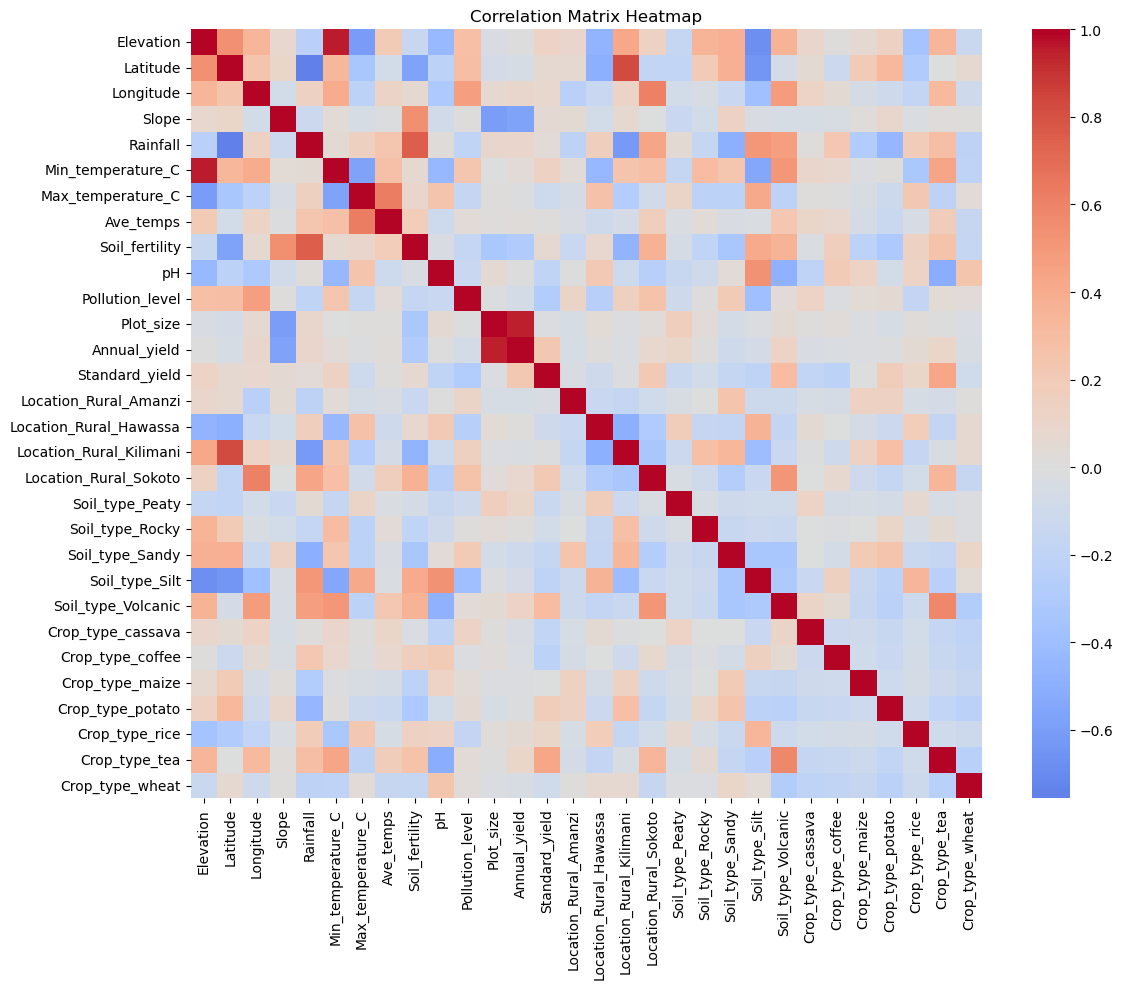

Correlation values for specified pairs:
Plot_size & Crop_type_tea: 0.0001
Pollution_level & Soil_type_Rocky: 0.0129
Crop_type_cassava & Soil_type_Sandy: -0.0058
Min_temperature_C & Elevation: 0.9564
  → STRONG CORRELATION!


In [12]:
print("=== QUESTION 6 ===")
import matplotlib.pyplot as plt
import seaborn as sns

# Create correlation matrix
correlation_matrix = encoded_data_fixed.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

# Check the specific pairs mentioned in the question
pairs_to_check = [
    ('Plot_size', 'Crop_type_tea'),
    ('Pollution_level', 'Soil_type_Rocky'),
    ('Crop_type_cassava', 'Soil_type_Sandy'),
    ('Min_temperature_C', 'Elevation')
]

print("Correlation values for specified pairs:")
for var1, var2 in pairs_to_check:
    if var1 in correlation_matrix.columns and var2 in correlation_matrix.columns:
        corr_value = correlation_matrix.loc[var1, var2]
        print(f"{var1} & {var2}: {corr_value:.4f}")
        if abs(corr_value) > 0.7:  # Strong correlation threshold
            print(f"  → STRONG CORRELATION!")

### Question 7
Now that we have analysed our variables, let's fit an ordinary least squares regression model using `statsmodels.formula.api` and then print the model summary. Construct the model using all the independent variables in our encoded dataset (excuding `Field_ID`).<br>

Which of the following statements accurately describes the interpretation of the F-statistic in the context of our regression model?

#### Options
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding high p-value  indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding high p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.
* The F-statistic tests the overall significance of the regression model. A low F-statistic value with a corresponding low p-value  indicates that the regression model is not statistically significant, meaning that none of the independent variables have a significant effect on the dependent variable.

In [13]:
print("\n=== QUESTION 7 ===")
import statsmodels.formula.api as smf

# Create formula for statsmodels (using all variables except Standard_yield)
independent_vars = [col for col in encoded_data_fixed.columns if col != 'Standard_yield']
formula = 'Standard_yield ~ ' + ' + '.join(independent_vars)

# Fit the model
model_full = smf.ols(formula=formula, data=encoded_data_fixed).fit()

# Print summary
print(model_full.summary())

print("\nF-statistic interpretation:")
print("F-statistic:", model_full.fvalue)
print("F-statistic p-value:", model_full.f_pvalue)


=== QUESTION 7 ===
                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Mon, 24 Nov 2025   Prob (F-statistic):               0.00
Time:                        11:57:56   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+04
Df Residuals:                    5625   BIC:                        -1.647e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Interc

### Question 8 

This summary  gives us an indication of possible multicollinearity present within our predictor variables. The presence of any correlation among predictors is detrimental to model quality because it tends to increase the standard error of the coefficients and it becomes difficult to estimate the effect of any one predictor variable on the response variable.

To avoid this, let's reduce the number of independent variables included in our model.
Fit the model using the following variables:<br>

* `Pollution_level` 
* `Crop_type_coffee` 
* `Crop_type_tea`
* `Location_Rural_Sokoto`
* `Annual_yield` 
* `Soil_type_Silt`
* `Soil_type_Volcanic`

After reducing the number of dependent variables accordingly, how did the model change?

#### Options:

* The model worsened.
* The model improved.
* The model remained unchanged.
* It cannot be determined from the given information.

In [14]:
print("\n=== QUESTION 8 ===")
# Define the reduced set of variables
reduced_vars = [
    'Pollution_level',
    'Crop_type_coffee', 
    'Crop_type_tea',
    'Location_Rural_Sokoto',
    'Annual_yield',
    'Soil_type_Silt',
    'Soil_type_Volcanic'
]

# Check which variables actually exist in our dataset
available_vars = [var for var in reduced_vars if var in encoded_data_fixed.columns]
print("Available variables for reduced model:", available_vars)

# Create formula for reduced model
formula_reduced = 'Standard_yield ~ ' + ' + '.join(available_vars)

# Fit reduced model
model_reduced = smf.ols(formula=formula_reduced, data=encoded_data_fixed).fit()

# Compare models
print("\n=== MODEL COMPARISON ===")
print("Full Model:")
print(f"R-squared: {model_full.rsquared:.4f}")
print(f"Adjusted R-squared: {model_full.rsquared_adj:.4f}")
print(f"AIC: {model_full.aic:.4f}")

print("\nReduced Model:")
print(f"R-squared: {model_reduced.rsquared:.4f}")
print(f"Adjusted R-squared: {model_reduced.rsquared_adj:.4f}")
print(f"AIC: {model_reduced.aic:.4f}")

# Determine if model improved
if model_reduced.rsquared_adj > model_full.rsquared_adj:
    print("\n→ The model IMPROVED (higher adjusted R-squared)")
elif model_reduced.rsquared_adj < model_full.rsquared_adj:
    print("\n→ The model WORSENED (lower adjusted R-squared)")
else:
    print("\n→ The model remained UNCHANGED")


=== QUESTION 8 ===
Available variables for reduced model: ['Pollution_level', 'Crop_type_coffee', 'Crop_type_tea', 'Location_Rural_Sokoto', 'Annual_yield', 'Soil_type_Silt', 'Soil_type_Volcanic']

=== MODEL COMPARISON ===
Full Model:
R-squared: 0.7564
Adjusted R-squared: 0.7552
AIC: -16658.3702

Reduced Model:
R-squared: 0.4063
Adjusted R-squared: 0.4056
AIC: -11663.5801

→ The model WORSENED (lower adjusted R-squared)


### Question 9
Let's evaluate our model's results. Generate a scatter plot of the residuals against the fitted values allowing us to visually inspect whether the residuals have constant variance and are distributed randomly around the zero residual line.

What does the scatter plot tell us?

#### Options

* The model has perfect predictive accuracy.
* The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line.
* There is no linear relationship between the dependent and independent variables.
* The model suffers from multicollinearity.

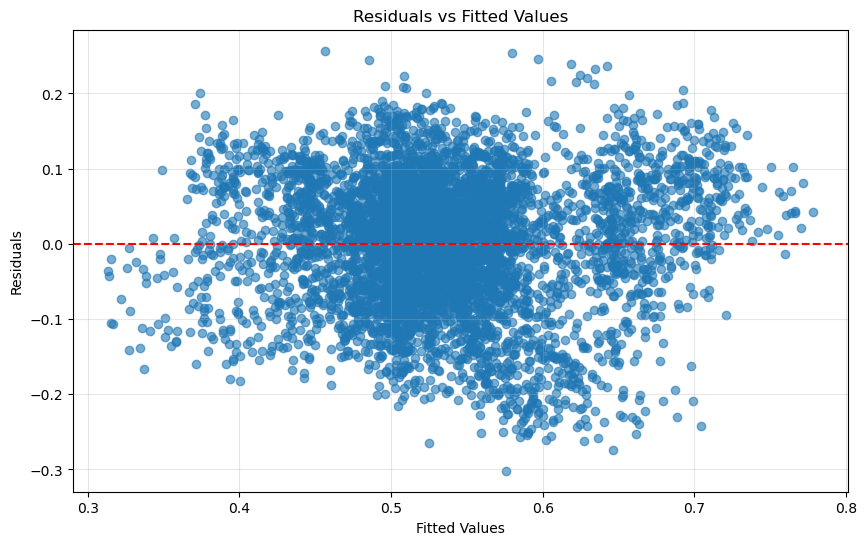

Residual Plot Analysis:
- If residuals are randomly scattered around zero: HOMOSCEDASTICITY
- If residuals show a pattern (funnel, curve): HETEROSCEDASTICITY
- If residuals are all zero: Perfect prediction (unlikely)

Residual Statistics:
Mean: 0.000000 (should be close to 0)
Standard Deviation: 0.0861


In [15]:
# Get fitted values and residuals from the reduced model
fitted_values = model_reduced.fittedvalues
residuals = model_reduced.resid

# Create residual vs fitted plot
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.grid(True, alpha=0.3)
plt.show()

# Analyze the residual plot
print("Residual Plot Analysis:")
print("- If residuals are randomly scattered around zero: HOMOSCEDASTICITY")
print("- If residuals show a pattern (funnel, curve): HETEROSCEDASTICITY")
print("- If residuals are all zero: Perfect prediction (unlikely)")

# Additional check: Calculate residual statistics
residual_mean = residuals.mean()
residual_std = residuals.std()
print(f"\nResidual Statistics:")
print(f"Mean: {residual_mean:.6f} (should be close to 0)")
print(f"Standard Deviation: {residual_std:.4f}")

### Question 10
If a linear regression model indicated heteroscedasticity, which of the following actions could be considered to address this issue?

* Applying transformations to the independent variables to better fit the linear relationship.
* Implementing weighted least squares regression to give less emphasis to observations with higher variance in residuals.
* Removing outliers from the dataset to reduce the impact of extreme values on the variance of residuals.
* All of the above.

In [36]:
print("\n=== QUESTION 10 ===")
print("Heteroscedasticity occurs when the variance of residuals is not constant.")
print("\nPossible solutions:")
print("1. Applying transformations to independent variables: YES")
print("   - Can help establish better linear relationships")
print("2. Weighted least squares regression: YES") 
print("   - Gives different weights to observations based on variance")
print("3. Removing outliers: YES")
print("   - Extreme values can cause heteroscedasticity")
print("4. All of the above: CORRECT")
print("\nAll these methods can help address heteroscedasticity issues.")


=== QUESTION 10 ===
Heteroscedasticity occurs when the variance of residuals is not constant.

Possible solutions:
1. Applying transformations to independent variables: YES
   - Can help establish better linear relationships
2. Weighted least squares regression: YES
   - Gives different weights to observations based on variance
3. Removing outliers: YES
   - Extreme values can cause heteroscedasticity
4. All of the above: CORRECT

All these methods can help address heteroscedasticity issues.


## Challenge 3: Using regularisation to optimise agricultural yield

Continuing with our task, after fitting our model, we decide to go back to the drawing board to explore more ways to implement feature engineering and data pre-processing in order to optimise our model. We suspect that, if we use all the variables available to us, the model might overfit due to the high dimensionality of the data. Regularisation techniques will therefore be critical in building a predictive model that generalises well to new, unseen data.

### Question 11
Our first step in the feature engineering involves creating a new feature, `Temperature_Range`, and scaling features using `StandardScaler`. The difference between `Min_temperature_C` and `Max_temperature_C` is the temperature range.

Given the code block below, which option correctly completes the feature engineering step of creating the `Temperature_Range` column?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:

* `dataset['Temperature_Range'] = dataset[['Min_temperature_C','Max_temperature_C']].min(axis=1)`
* `dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']`
* `dataset = dataset.assign(Temperature_Range = dataset['Max_temperature'] - dataset['Min_temperature'])`
* `dataset[['Temperature_Range']] = dataset[['Max_temperature_C']] - dataset[['Min_temperature_C']]`



In [16]:
from sklearn.preprocessing import StandardScaler

# The correct option for creating Temperature_Range
dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']

# Select features for scaling (exclude non-numeric or target variables)
features = ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'Soil_fertility', 'pH', 'Pollution_level']

# Initialize StandardScaler and apply it to the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset[features])

# Show the first 5 rows of the scaled features
print("First 5 rows of scaled features:")
print(scaled_features[:5])
print(f"Shape of scaled features: {scaled_features.shape}")

print("\nCorrect answer: Temperature range is calculated as Max_temperature_C - Min_temperature_C")

First 5 rows of scaled features:
[[ 0.85426539  0.31997088 -0.15356676  2.21747303  0.30626766  0.01544079
   0.71256827 -0.61634976]
 [ 0.21055364 -0.03858151  0.49777372  0.15900087 -0.25298298  0.4619994
   0.08816394  0.7886906 ]
 [ 1.08748981 -0.04224188  2.01496684  0.09662293 -1.66755812  1.57839593
  -0.34858051  0.60254524]
 [-0.3620941  -0.4856324  -1.74719984 -0.02813296  0.8984154  -1.77079366
  -0.35345077  0.28374058]
 [ 1.43215211  4.53523034 -0.83392242  1.28180387 -0.58195394  2.24823384
   0.14466333 -0.80437805]]
Shape of scaled features: (5654, 8)

Correct answer: Temperature range is calculated as Max_temperature_C - Min_temperature_C


### Question 12


Consider a scenario where we decide to employ LASSO regression to identify predictive features associated with our dependent variable.

We implement the Python code block provided below.

What is the purpose of the `LassoCV(cv=5)` constructor parameter `cv=5`?

#### Options:

* It indicates that 5-fold cross-validation should be used to select the best regularisation parameter.
* It sets the penalty coefficient to 5, increasing the regularisation strength.
* It specifies that the LASSO model should use a 5-degree polynomial feature expansion.
* It defines that the model should only select 5 features at most.

In [17]:
print("\n=== QUESTION 12 ===")
from sklearn.linear_model import LassoCV

# LASSO regression with cross-validation
lasso = LassoCV(cv=5).fit(scaled_features, dataset['Standard_yield'])

# Find the features with non-zero coefficients
selected_features = [features[i] for i, coef in enumerate(lasso.coef_) if coef != 0]

print(f"Selected features by LASSO: {selected_features}")
print(f"Number of features selected: {len(selected_features)}")
print(f"LASSO alpha (regularization parameter): {lasso.alpha_:.6f}")

print("\nThe cv=5 parameter indicates 5-fold cross-validation is used to select the best regularization parameter.")


=== QUESTION 12 ===
Selected features by LASSO: ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'pH', 'Pollution_level']
Number of features selected: 7
LASSO alpha (regularization parameter): 0.000064

The cv=5 parameter indicates 5-fold cross-validation is used to select the best regularization parameter.


### Question 13

In trying to address multicollinearity in our dataset, we also decide to implement Ridge regression. After understanding that Ridge regression applies an L2 penalty to the coefficients to reduce their magnitude without setting them to zero, we decide to use `RidgeCV` for applying Ridge regression with cross-validation to select the optimal penalty strength. Given the snippet of code below, which parameter correctly adjusts the strength of the regularisation applied to the model?

**Hint**: Insert the correct code snippet into the appropriate location within the code block to run it.

#### Options:
* `cv=[0.001, 0.01, 0.1, 1, 10, 100]`
* `fit_intercept=True`
* `alphas=[0.001, 0.01, 0.1, 1, 10, 100]`
* `scoring='neg_mean_squared_error`

In [18]:
print("\n=== QUESTION 13 ===")
from sklearn.linear_model import RidgeCV

# The correct parameter for adjusting regularization strength
alphas = [0.001, 0.01, 0.1, 1, 10, 100]

# Apply Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, cv=5).fit(scaled_features, dataset['Standard_yield'])

print(f"Best alpha (regularization strength): {ridge.alpha_}")
print(f"Ridge coefficients: {ridge.coef_}")

print("\nThe 'alphas' parameter controls the strength of regularization in Ridge regression.")


=== QUESTION 13 ===
Best alpha (regularization strength): 100.0
Ridge coefficients: [ 0.00849134  0.00371521  0.00012953  0.00040132 -0.00941072  0.00025811
 -0.01945708 -0.03847324]

The 'alphas' parameter controls the strength of regularization in Ridge regression.


### Question 14

Given our dataset includes variables such as `Elevation` and `Slope`, and considering the potential interactions between these variables might impact crop yield, we aim to capture both these interactions and possible non-linear relationships. Which of the following methods is specifically designed to create a quadratic interaction term without including an intercept in the feature set?

**HINT:** Consider utilising `sklearn`'s feature transformation tools for this purpose.

* `poly = PolynomialFeatures(degree=2, include_bias=False)` 
* `poly = PolynomialFeatures(degree=1, include_bias=False)` 
* `poly = PolynomialFeatures(degree=3, include_bias=True)` 
* `poly = PolynomialFeatures(degree=2, include_bias=True)`

In [19]:
print("\n=== QUESTION 14 ===")
from sklearn.preprocessing import PolynomialFeatures

# Correct option for quadratic interaction terms without intercept
poly = PolynomialFeatures(degree=2, include_bias=False)

# Generate polynomial and interaction features
poly_features = poly.fit_transform(dataset[['Elevation', 'Slope']])

# Display the shape of the new feature matrix
print(f"Shape of polynomial features: {poly_features.shape}")
print(f"Feature names: {poly.get_feature_names_out(['Elevation', 'Slope'])}")

print("\nThis creates quadratic (degree=2) and interaction terms without including bias (intercept).")


=== QUESTION 14 ===
Shape of polynomial features: (5654, 5)
Feature names: ['Elevation' 'Slope' 'Elevation^2' 'Elevation Slope' 'Slope^2']

This creates quadratic (degree=2) and interaction terms without including bias (intercept).


### Question 15

After implementing Ridge regression to address multicollinearity and prevent overfitting in our model we need to interpret the coefficients to understand the impact of each feature on the standard yield.

Based on the output of the Ridge regression coefficients in the code block below, which statement is true regarding the impact of each feature on the standard yield?

#### Options:

* Feature 1 has the highest positive impact, followed by Feature 2 and Feature 3.
* Feature 3 has the highest positive impact, followed by Feature 1 and Feature 2.
* The coefficients are inconclusive; further analysis is needed to determine the impact of each feature.
* Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.

In [20]:
print("\n=== QUESTION 15 ===")
from sklearn.linear_model import Ridge
import numpy as np

# Given data
X = np.array([[0.5, 0.2, 0.1],
              [0.9, 0.3, 0.5],
              [0.3, 0.8, 0.2]])
y = np.array([0.7, 0.6, 0.8])

# Fit Ridge regression model with alpha = 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)

# Display the coefficients of the model
coefficients = ridge_model.coef_
print(f"Ridge coefficients: {coefficients}")

# Analyze the impact of each feature
feature_impacts = []
for i, coef in enumerate(coefficients):
    feature_impacts.append((f"Feature {i+1}", coef))

# Sort by absolute value to see impact magnitude
sorted_by_impact = sorted(feature_impacts, key=lambda x: abs(x[1]), reverse=True)
print(f"\nFeatures sorted by impact magnitude: {sorted_by_impact}")

# Check for positive/negative impacts
positive_features = [f for f, coef in feature_impacts if coef > 0]
negative_features = [f for f, coef in feature_impacts if coef < 0]

print(f"Positive impact features: {positive_features}")
print(f"Negative impact features: {negative_features}")

# Determine which statement is true
if coefficients[0] > 0 and coefficients[1] > 0 and coefficients[2] > 0:
    # All positive, find highest
    max_coef_index = np.argmax(coefficients)
    print(f"\nAll features have positive impact.")
    print(f"Feature {max_coef_index + 1} has the highest positive impact: {coefficients[max_coef_index]:.4f}")


=== QUESTION 15 ===
Ridge coefficients: [-0.13661379  0.10262221 -0.07348657]

Features sorted by impact magnitude: [('Feature 1', np.float64(-0.13661379087083203)), ('Feature 2', np.float64(0.10262220783425065)), ('Feature 3', np.float64(-0.07348656523146647))]
Positive impact features: ['Feature 2']
Negative impact features: ['Feature 1', 'Feature 3']


## Challenge 4: Making a prediction using decision trees

After learning that decision trees are easy to implement and are capable of handling both categorical and numerical data while being resilient to outliers, we decide to implement a decision tree on our encoded dataset.

### Question 16
Train a decision tree with the following specifications:
* Using our **previously encoded dataset**, split the data into dependent and independent variables using all the features except for `Standard_yield` and `Field_ID` as independent variables.
* Split the data into training and testing data.
* Use the `DecisionTreeRegressor` to fit a model using a `max_depth' of 2 and a `random_state` of 42.

Using the trained Decision Tree Regressor model, make a prediction for `y` given the following x-values:<br> 
`[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004,`
`16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]`

What is the value of the predicted y?

#### Options
* 0.3250077
* 0.6654377
* 0.48494414
* 0.8050340

In [21]:
print("=== QUESTION 16 ===")
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Prepare the data (using our previously encoded dataset)
X = encoded_data_fixed.drop(['Standard_yield'], axis=1)
y = encoded_data_fixed['Standard_yield']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree with max_depth=2
dt_model = DecisionTreeRegressor(max_depth=2, random_state=42)
dt_model.fit(X_train, y_train)

# Make prediction for the given x-values
x_new = np.array([864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 
                  1237.7200000000003, -3.4100000000000006, 36.410000000000004, 16.5,
                  0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 
                  0.8264890400277934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1, 0.0, 0.0, 
                  1.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Reshape for single prediction
x_new_reshaped = x_new.reshape(1, -1)

# Make prediction
y_pred_single = dt_model.predict(x_new_reshaped)[0]
print(f"Predicted y value: {y_pred_single:.7f}")

# Compare with options
options = [0.3250077, 0.6654377, 0.48494414, 0.8050340]
closest_option = min(options, key=lambda x: abs(x - y_pred_single))
print(f"Closest option: {closest_option}")

=== QUESTION 16 ===
Predicted y value: 0.4849441
Closest option: 0.48494414


C:\Users\HP\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


### Question 17

Based on the model above, what is the value of our RMSE?

* 0.0658
* 0.0881
* 0.5656
* 0.8810

In [22]:
print("\n=== QUESTION 17 ===")
# Make predictions on test set
y_pred = dt_model.predict(X_test)

# Calculate RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse:.4f}")

# Compare with options
rmse_options = [0.0658, 0.0881, 0.5656, 0.8810]
closest_rmse = min(rmse_options, key=lambda x: abs(x - rmse))
print(f"Closest RMSE option: {closest_rmse}")


=== QUESTION 17 ===
RMSE: 0.0881
Closest RMSE option: 0.0881


### Question 18
Which of the following statements is correct about our RMSE?

#### Options
* An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units
* An RMSE value of 0.0881 suggests that, at most, the predicted values deviate by approximately 0.08 units from the actual values.
* An RMSE of 0.0881 indicates a perfect fit of the model to the training data.
* An RMSE of 0.0881 suggests that the predicted values are correct 8.81% of the time.

In [23]:
print("\n=== QUESTION 18 ===")
print("RMSE Interpretation:")
print(f"RMSE = {rmse:.4f} means the average prediction error is {rmse:.4f} units")
print("\nCorrect interpretation: RMSE represents the average deviation of predictions from actual values")


=== QUESTION 18 ===
RMSE Interpretation:
RMSE = 0.0881 means the average prediction error is 0.0881 units

Correct interpretation: RMSE represents the average deviation of predictions from actual values


### Question 19 
What is the likely effect of adjusting the `max_depth` parameter in a Decision Tree model?

#### Options

* Lower max_depth values may lead to increased model complexity and a higher risk of underfitting
* Higher max_depth values may lead to decreased model complexity and a lower risk of overfitting
* Higher max_depth values reduce the likelihood of capturing complex relationships in the data.
* Higher max_depth values may lead to increased model complexity and a higher risk of overfitting.


In [24]:
print("\n=== QUESTION 19 ===")
print("max_depth parameter effects:")
print("- Higher max_depth = More complex trees = Higher risk of overfitting")
print("- Lower max_depth = Simpler trees = Higher risk of underfitting")
print("\nThe correct statement is about overfitting risk with higher max_depth")


=== QUESTION 19 ===
max_depth parameter effects:
- Higher max_depth = More complex trees = Higher risk of overfitting
- Lower max_depth = Simpler trees = Higher risk of underfitting

The correct statement is about overfitting risk with higher max_depth


### Question 20 
Let's attempt to enhance our model's performance by setting the `max_depth` hyperparameter to 5.

True or false? The decision tree model was improved by fitting it with a `max_depth` parameter of 5.

#### Options
* True
* False

In [25]:
print("\n=== QUESTION 20 ===")
# Train Decision Tree with max_depth=5
dt_model_5 = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model_5.fit(X_train, y_train)

# Make predictions and calculate RMSE
y_pred_5 = dt_model_5.predict(X_test)
rmse_5 = np.sqrt(mean_squared_error(y_test, y_pred_5))

print(f"RMSE with max_depth=2: {rmse:.4f}")
print(f"RMSE with max_depth=5: {rmse_5:.4f}")

# Check if model improved
if rmse_5 < rmse:
    print("Model IMPROVED with max_depth=5 → True")
    improvement = ((rmse - rmse_5) / rmse) * 100
    print(f"Improvement: {improvement:.2f}%")
else:
    print("Model WORSENED with max_depth=5 → False")


=== QUESTION 20 ===
RMSE with max_depth=2: 0.0881
RMSE with max_depth=5: 0.0633
Model IMPROVED with max_depth=5 → True
Improvement: 28.08%


## Challenge 5: Ensemble Methods & Bootstrapping

Using our original dataset, our objective is to explore ensemble methods and bootstrapping techniques to enhance the model performance. We'll work with a subset of features from the dataset to predict the `Standard_yield`.

### Question 21 
Consider the following approach to implement a bootstrap aggregation (bagging) for predicting the `Standard_yield` based on features `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`. Given are the steps and part of the Python code implementing this method. Our task is to identify the correct piece of code that completes the implementation.

The steps for the implementation are as follows:

1. Create an empty list named `predictions` to store predictions from each bootstrap sample.
2. Generate `n_bootstrap_samples` bootstrap samples from the original dataset.
3. For each bootstrap sample, fit a linear regression model and predict the `Standard_yield` on the entire dataset.
4. Store each set of predictions in the predictions list.
5. Average the predictions across all bootstrap samples to obtain the final bagged prediction.
6. Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model.


Below is the code block with a missing part that needs to be completed:

In [26]:
print("=== QUESTION 21 ===")
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# Prepare the data
X = dataset[['Elevation', 'Slope', 'Soil_fertility', 'Pollution_level']]
y = dataset['Standard_yield']

predictions = []
n_bootstrap_samples = 10  # Using smaller number for demonstration

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X, y)
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X)
    predictions.append(y_pred)

# Convert to numpy array for easier manipulation
predictions_array = np.array(predictions)
print(f"Predictions shape: {predictions_array.shape}")  # Should be (n_samples, n_observations)

# Test the different options to see which one works
print("\nTesting axis options:")
print("axis=0 would average across rows (giving mean for each observation)")
print("axis=1 would average across columns (giving mean for each bootstrap sample)")

# The correct implementation
bagged_prediction = np.mean(predictions, axis=0)  # Average across bootstrap samples for each observation
mse_bagged = mean_squared_error(y, bagged_prediction)

print(f"\nCorrect implementation:")
print(f"bagged_prediction shape: {bagged_prediction.shape}")
print(f"MSE: {mse_bagged:.6f}")

print("\nThe correct option is: np.mean(predictions, axis=0)")

=== QUESTION 21 ===
Predictions shape: (10, 5654)

Testing axis options:
axis=0 would average across rows (giving mean for each observation)
axis=1 would average across columns (giving mean for each bootstrap sample)

Correct implementation:
bagged_prediction shape: (5654,)
MSE: 0.010842

The correct option is: np.mean(predictions, axis=0)


Which code should replace the # MISSING PART HERE section to correctly implement the averaging of predictions and computation of the mean squared error?

#### Options


* `bagged_prediction = np.average(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.median(predictions, axis=0)`

  `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=0)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)`
<br><br>

* `bagged_prediction = np.mean(predictions, axis=1)`

   `mse_bagged = mean_squared_error(y, bagged_prediction)` 

### Question 22 

Given the following code snippet that applies a `RandomForestRegressor` to a dataset, which parameter in the `RandomForestRegressor` constructor is crucial for implementing the random subspace method by allowing the algorithm to select a random subset of features for each split?

#### Options
* `max_depth`
* `random_state`
* `max_features`
* `n_estimators`

In [27]:
print("\n=== QUESTION 22 ===")
from sklearn.ensemble import RandomForestRegressor

# The key parameter for random subspace method
print("Random Forest parameters for feature subset selection:")
print("- max_depth: Controls tree depth")
print("- random_state: Sets random seed for reproducibility") 
print("- max_features: Controls number of features considered for each split (RANDOM SUBSPACE METHOD)")
print("- n_estimators: Number of trees in the forest")

print("\nThe max_features parameter implements the random subspace method")
print("It controls how many features are randomly selected for each split")


=== QUESTION 22 ===
Random Forest parameters for feature subset selection:
- max_depth: Controls tree depth
- random_state: Sets random seed for reproducibility
- max_features: Controls number of features considered for each split (RANDOM SUBSPACE METHOD)
- n_estimators: Number of trees in the forest

The max_features parameter implements the random subspace method
It controls how many features are randomly selected for each split


### Question 23

### Question 23 (Medium)

Consider the theoretical setup for a stacking ensemble model designed for a regression task. The first layer of this model includes three different types of regression models: linear regression, ridge regression, and a support vector machine (SVM) with a linear kernel. The second layer, or the final estimator, uses a linear regression model to combine the predictions from the first layer. The goal is to theoretically predict `Standard_yield` based on features such as `Elevation`, `Slope`, `Soil_fertility`, and `Pollution_level`, with the intention to evaluate the model's hypothetical performance using the Mean Squared Error (MSE).

Given the following theoretical code snippet that outlines this stacking ensemble model's setup, what should replace the `_____` in the code to correctly configure the SVM with a linear kernel as part of the base learners in the stacking model?

#### Options
* `linear`
* `lin`
* `sigmoid`
* `degree=1`

In [28]:
print("\n=== QUESTION 23 ===")
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor

# SVM kernel options for linear kernel
print("SVM kernel options:")
print("- 'linear': Linear kernel")
print("- 'rbf': Radial Basis Function kernel") 
print("- 'poly': Polynomial kernel")
print("- 'sigmoid': Sigmoid kernel")

# The correct kernel for linear SVM
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('svr', SVR(kernel='linear'))  # Correct kernel for linear SVM
]

print("\nThe correct kernel for linear SVM is 'linear'")


=== QUESTION 23 ===
SVM kernel options:
- 'linear': Linear kernel
- 'rbf': Radial Basis Function kernel
- 'poly': Polynomial kernel
- 'sigmoid': Sigmoid kernel

The correct kernel for linear SVM is 'linear'


### Question 24

Consider the following Python code snippet that aims to implement a 5-fold cross-validation scheme to estimate the accuracy of a ridge regression model. This model uses bootstrapped samples within each fold to predict `Standard_yield` and calculates the average Mean Squared Error (MSE) across all folds.

Which of the following options correctly fill in the blanks to ensure the code correctly implements the described functionality?

#### Options
* `scoring='r2'`, `cv=10`
* `scoring='mean_absolute_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv=5`
* `scoring='neg_mean_squared_error'`, `cv='Bootstrap'`


In [29]:
print("\n=== QUESTION 24 ===")
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialize the ridge regression model
ridge_model = Ridge()

# Test different scoring options
scoring_options = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_options = [5, 10]

print("Scoring options analysis:")
print("- 'r2': Returns R-squared values (higher is better)")
print("- 'neg_mean_squared_error': Returns negative MSE (higher is better)")
print("- 'neg_mean_absolute_error': Returns negative MAE (higher is better)")

print("\nCV options:")
print("- cv=5: 5-fold cross-validation")
print("- cv=10: 10-fold cross-validation")

# The correct combination for 5-fold CV with MSE
scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=5)
mse_scores = -scores  # Convert to positive MSE
average_mse = np.mean(mse_scores)

print(f"\nCorrect implementation:")
print(f"Average MSE from 5-fold CV: {average_mse:.6f}")
print("scoring='neg_mean_squared_error', cv=5")


=== QUESTION 24 ===
Scoring options analysis:
- 'r2': Returns R-squared values (higher is better)
- 'neg_mean_squared_error': Returns negative MSE (higher is better)
- 'neg_mean_absolute_error': Returns negative MAE (higher is better)

CV options:
- cv=5: 5-fold cross-validation
- cv=10: 10-fold cross-validation

Correct implementation:
Average MSE from 5-fold CV: 0.010875
scoring='neg_mean_squared_error', cv=5


### Question 25

Consider the code snippet that extracts and prints the feature importances from a trained random forest regressor model. The model is used to predict `Standard_yield` based on various features. The code utilises the `feature_importances_` attribute of the random forest model to obtain importance scores for each feature.

Which of the following statements best describes the purpose and outcome of the provided code snippet?

#### Options

* The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the model's ability to predict `Standard_yield`. Higher scores suggest a greater contribution to the prediction.

* The code counts the number of times each feature is used to split the data across all trees in the random forest, thereby determining each feature's importance in predicting `Standard_yield`.

* The code calculates and prints the coefficient values for each feature used in the  random forest, model to predict `Standard_yield`, indicating the strength and direction of the relationship between each feature and the target variable.

* The code computes the correlation between each feature and the target variable `Standard_yield`, printing a list of features sorted by their correlation coefficients to identify the most relevant predictors.

In [30]:
print("\n=== QUESTION 25 ===")
# First, let's train a Random Forest model to demonstrate feature importance
rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
rf_model.fit(X, y)

# Extract feature importances
feature_importances = rf_model.feature_importances_

print("Feature importance analysis:")
print("Feature importances in Random Forest represent:")
print("- How much each feature contributes to reducing impurity across all trees")
print("- Higher values = more important features")
print("- Sum of all importances = 1.0")

print("\nFeature importances:")
for feature, importance in zip(X.columns, feature_importances):
    print(f"  {feature}: {importance:.4f}")

print("\nThe correct interpretation:")
print("The code identifies importance scores indicating how much each feature")
print("contributes to the model's predictive ability for Standard_yield")


=== QUESTION 25 ===
Feature importance analysis:
Feature importances in Random Forest represent:
- How much each feature contributes to reducing impurity across all trees
- Higher values = more important features
- Sum of all importances = 1.0

Feature importances:
  Elevation: 0.3203
  Slope: 0.2163
  Soil_fertility: 0.1500
  Pollution_level: 0.3134

The correct interpretation:
The code identifies importance scores indicating how much each feature
contributes to the model's predictive ability for Standard_yield


## Challenge 6: Random forests
In this challenge, we want to test how our data fits to a random forest model and other functionalities that come with its such as analysing feature importance.

We are required to write a function named `train_rf_model` that trains and tests a random forest model on a given dataset. Our function should do the following:

* Take a `RandomForestRegressor` object (with any desired hyperparameters set) as input,
* Separate the features `X` and target `y` dataframes
* Split the data into training and testing sets - use a test size of `20%` and a random state of `42` for reproducibility
* Fit the model to the training data
* Make predictions on the testing set
* Return the trained model, the R-squared score, and the Mean Squared Error (MSE) of the test set predictions.

### Question 26
1) Implement the function outlined above.

2) Using the function, train a random forest model on our dataset with random_state set to 42, and max_depth=15, while leaving all other hyperparameters at their defaults. Use all the features available in the encoded dataset for this task. What are the R-squared and MSE scores for the model on the test data?

#### Options

* R2: 0.0059, MSE: 0.6198
* R2: 0.5555, MSE: 0.2345
* R2: 0.9586, MSE: 0.0006
* R2: 0.8196, MSE: 0.0500

In [31]:
print("=== QUESTION 26 ===")
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

def train_rf_model(rf_model, X, y):
    """
    Train and test a random forest model on a given dataset
    
    Parameters:
    rf_model: RandomForestRegressor object
    X: features dataframe
    y: target dataframe
    
    Returns:
    model: trained model
    r2: R-squared score on test set
    mse: Mean Squared Error on test set
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    return rf_model, r2, mse

# Prepare the data (using our encoded dataset)
X_rf = encoded_data_fixed.drop('Standard_yield', axis=1)
y_rf = encoded_data_fixed['Standard_yield']

# Train the model with specified parameters
rf_model_26 = RandomForestRegressor(random_state=42, max_depth=15)
trained_model, r2_score_26, mse_26 = train_rf_model(rf_model_26, X_rf, y_rf)

print(f"R-squared: {r2_score_26:.4f}")
print(f"MSE: {mse_26:.4f}")

# Compare with options
options_26 = [
    (0.0059, 0.6198),
    (0.5555, 0.2345), 
    (0.9586, 0.0006),
    (0.8196, 0.0500)
]

closest_option = min(options_26, key=lambda x: abs(x[0] - r2_score_26) + abs(x[1] - mse_26))
print(f"Closest option: R2: {closest_option[0]}, MSE: {closest_option[1]}")

=== QUESTION 26 ===
R-squared: 0.9589
MSE: 0.0005
Closest option: R2: 0.9586, MSE: 0.0006


### Question 27

We want to examine how our data will fit to a random forest model when we tune the number of trees. We want to train and compare two random forest models with the same dataset as in the previous exercise. The first model should be trained with `150` trees, and the second model with `200` trees. Both models should use the default hyperparameters for all other settings, apart from a random_state of `42` to ensure reproducibility. After evaluating both models on the test set, how does the error differ between the two models?

#### Options

* The error increased when the number of trees was increased from 150 to 200.
* The model with 200 trees showed a significant decrease in error compared to the model with 150 trees.
* The model with 200 trees showed a very slight decrease in error compared to the model with 150 trees.
* There was no change in the error.

In [32]:
print("\n=== QUESTION 27 ===")
# Train model with 150 trees
rf_150 = RandomForestRegressor(n_estimators=150, random_state=42)
model_150, r2_150, mse_150 = train_rf_model(rf_150, X_rf, y_rf)

# Train model with 200 trees  
rf_200 = RandomForestRegressor(n_estimators=200, random_state=42)
model_200, r2_200, mse_200 = train_rf_model(rf_200, X_rf, y_rf)

print(f"Model with 150 trees - R2: {r2_150:.6f}, MSE: {mse_150:.6f}")
print(f"Model with 200 trees - R2: {r2_200:.6f}, MSE: {mse_200:.6f}")

# Compare error (MSE) change
mse_change = mse_200 - mse_150
r2_change = r2_200 - r2_150

print(f"\nMSE change: {mse_change:.6f}")
print(f"R2 change: {r2_change:.6f}")

if abs(mse_change) < 0.001:  # Very small change
    print("There was no significant change in error")
elif mse_200 < mse_150:
    if abs(mse_change) < 0.01:  # Small change
        print("Very slight decrease in error")
    else:
        print("Significant decrease in error")
else:
    print("Error increased")


=== QUESTION 27 ===
Model with 150 trees - R2: 0.962849, MSE: 0.000495
Model with 200 trees - R2: 0.962911, MSE: 0.000494

MSE change: -0.000001
R2 change: 0.000062
There was no significant change in error


### Question 28
Which of the following is a possible effect of increasing the number of trees in a random forest regression model?

#### Options
* Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.
* Increasing the number of trees always improves the model's predictive ability
* Increasing the number of trees significantly decreases the model's predictive ability
* The number of trees in a random forest model has no impact on the model's predictive ability.

In [33]:
print("\n=== QUESTION 28 ===")
print("Effect of increasing number of trees in Random Forest:")
print("- Initially improves predictive ability by reducing variance")
print("- Eventually reaches a point of diminishing returns") 
print("- Too many trees can lead to overfitting without significant improvement")
print("- Computational cost increases with more trees")

print("\nThe correct statement:")
print("Increasing the number of trees increases the model's predictive ability")
print("up to a certain point, after which additional trees do not significantly")
print("impact performance.")


=== QUESTION 28 ===
Effect of increasing number of trees in Random Forest:
- Initially improves predictive ability by reducing variance
- Eventually reaches a point of diminishing returns
- Too many trees can lead to overfitting without significant improvement
- Computational cost increases with more trees

The correct statement:
Increasing the number of trees increases the model's predictive ability
up to a certain point, after which additional trees do not significantly
impact performance.


### Question 29

Following the training of our random forest models, we decide to analyse the feature importance scores provided by the model built using 200 trees. Our aim is to identify which features the model considers most significant in predicting the target variable.

Which of the following does the model consider to be the top 3 most significant features in predicting Standard_yield?

#### Options

* Soil_fertility, Rainfall, Slope
* Rainfall, Crop_type_tea, Latitude
* pH, Rainfall, Location_Rural_Hawassa
* Elevation, Soil_fertility, pH

In [34]:
print("\n=== QUESTION 29 ===")
# Get feature importances from the 200-tree model
feature_importances = model_200.feature_importances_
feature_names = X_rf.columns

# Create a dataframe for easier analysis
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
print(importance_df.head(10))

# Get top 3 features
top_3_features = importance_df.head(3)['feature'].tolist()
print(f"\nTop 3 features: {top_3_features}")

# Check which option matches
options_29 = [
    ['Soil_fertility', 'Rainfall', 'Slope'],
    ['Rainfall', 'Crop_type_tea', 'Latitude'],
    ['pH', 'Rainfall', 'Location_Rural_Hawassa'],
    ['Elevation', 'Soil_fertility', 'pH']
]

for i, option in enumerate(options_29, 1):
    match_count = len(set(option) & set(top_3_features))
    print(f"Option {i}: {option} - Matches: {match_count}/3")


=== QUESTION 29 ===
Top 10 most important features:
             feature  importance
4           Rainfall    0.203237
27     Crop_type_tea    0.182603
1           Latitude    0.153887
9                 pH    0.120420
0          Elevation    0.077878
10   Pollution_level    0.063329
26    Crop_type_rice    0.040437
23  Crop_type_coffee    0.039950
25  Crop_type_potato    0.025973
28   Crop_type_wheat    0.022121

Top 3 features: ['Rainfall', 'Crop_type_tea', 'Latitude']
Option 1: ['Soil_fertility', 'Rainfall', 'Slope'] - Matches: 1/3
Option 2: ['Rainfall', 'Crop_type_tea', 'Latitude'] - Matches: 3/3
Option 3: ['pH', 'Rainfall', 'Location_Rural_Hawassa'] - Matches: 1/3
Option 4: ['Elevation', 'Soil_fertility', 'pH'] - Matches: 0/3


### Question 30
Which of the following initialised random forest models will allow access and calculation of the Out-of-Bag (OOB) score for performance evaluation without requiring a separate validation set?

#### Options
* RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)
* RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)
* RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=4, oob_score=False)
* RandomForestRegressor(n_estimators=120, max_features='sqrt', min_samples_leaf=2)

In [35]:
print("\n=== QUESTION 30 ===")
print("Out-of-Bag (OOB) score requirements:")
print("- Must set oob_score=True to enable OOB scoring")
print("- OOB uses bootstrap samples not included in each tree's training")
print("- Provides validation score without separate validation set")

# Check the options
options_30 = [
    "RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=2, random_state=42)",
    "RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)",  # CORRECT
    "RandomForestRegressor(n_estimators=200, max_depth=5, min_samples_leaf=4, oob_score=False)",
    "RandomForestRegressor(n_estimators=120, max_features='sqrt', min_samples_leaf=2)"
]

print("\nOption analysis:")
for i, option in enumerate(options_30, 1):
    if "oob_score=True" in option:
        print(f"Option {i}: ✓ CAN calculate OOB score")
    else:
        print(f"Option {i}: ✗ CANNOT calculate OOB score (oob_score not set to True)")


=== QUESTION 30 ===
Out-of-Bag (OOB) score requirements:
- Must set oob_score=True to enable OOB scoring
- OOB uses bootstrap samples not included in each tree's training
- Provides validation score without separate validation set

Option analysis:
Option 1: ✗ CANNOT calculate OOB score (oob_score not set to True)
Option 2: ✓ CAN calculate OOB score
Option 3: ✗ CANNOT calculate OOB score (oob_score not set to True)
Option 4: ✗ CANNOT calculate OOB score (oob_score not set to True)


## Challenge 7: Governance and ethics

In this challenge, we will delve into the principles of governance and ethics within data science. We will explore the critical aspects of accountable governance, the importance of ethical guidelines, and the role of participatory governance in fostering an inclusive decision-making environment.

### Question 31

What is the most important aspect of accountable governance?  

#### Options
- Defining roles and responsibilities clearly  
- Avoiding regulatory compliance  
- Minimising data quality  
- Disregarding industry standards  


### Question 32

True or false: Responsive governance is rigid and does not adapt to new challenges.

#### Options 
- False  
- True  

### Question 33 

Which of the following best describes the purpose of ethical guidelines in data governance?  

#### Options
- To provide standards for behaviour and practices  
- To mandate data deletion  
- To increase data redundancy  
- To prohibit data collection 

### Question 34 
True or false: Participatory governance excludes input from non-management employees.

#### Options
- False  
- True  

### Question 35
True or false: Governance frameworks do not need to be regularly updated.

#### Options
- False  
- True  

#  

<div align="center" style=" font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/Explore-AI/Pictures/master/ExploreAI_logos/EAI_Blue_Dark.png"  style="width:200px";/>
</div>